# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration - Cleaning - Pre-Processing

## a. Portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


-----Portfolio DF Shape-----


(10, 6)

-----Portfolio DF Columns Types-----


channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

-----Portfolio DF Columns Description-----


,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


-----Portfolio DF Null Variables-----


channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

-----Portfolio DF Unique IDs Percentage-----
100.0 %

-----Portfolio DF Numeric Columns Analysis-----


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4010d9e550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe7c920f0>]], dtype=object)

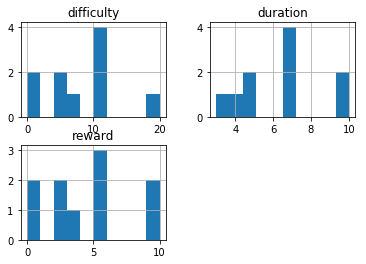

In [2]:
display(portfolio.head())
print("-----Portfolio DF Shape-----")
display(portfolio.shape)
print("-----Portfolio DF Columns Types-----")
display(portfolio.dtypes)
print("-----Portfolio DF Columns Description-----")
display(portfolio.describe())
print("-----Portfolio DF Null Variables-----")
display(portfolio.isnull().sum())
print("-----Portfolio DF Unique IDs Percentage-----")
print(f"{portfolio['id'].nunique() / portfolio.shape[0] *100} %\n")
print("-----Portfolio DF Numeric Columns Analysis-----")
display(portfolio.hist())

### Preprocessing Portfolio DF

In [3]:
def preprocess_portfolio(df):
    """
    Pre-processes the portfolio dataframe
    
    Input:
        - df
            - type: DataFrame
            - Includes the Portfolio Dataframe
            
    Output:
        - clean_df
            - type: DataFrame
            - Includes the One Hot Encoded and cleaned Portfolio DF
    """
    
    # One hot encode the offer_type column
    offer_type = pd.get_dummies(df['offer_type'])

    # One hot encode form a list the 
    mlb = MultiLabelBinarizer()
    df = df.join(pd.DataFrame(mlb.fit_transform(df.pop('channels')),
                          columns=mlb.classes_,
                          index=df.index))
    
    # frop the offer_type column
    df.drop(columns=['offer_type'], inplace=True)

    # concatinate the one hot encoded offer_type to the original df
    clean_df = pd.concat([df, offer_type], axis=1)
    
    return clean_df

cleaned_portfolio = preprocess_portfolio(portfolio.copy())
cleaned_portfolio

,difficulty,duration,id,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,0,1,0,1,0


## b. Profile 

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


-----Profile DF Shape-----


(17000, 5)

-----Profile DF Columns Types-----


age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

-----Profile DF Columns Description-----


,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


-----Profile DF Null Variables-----


age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

-----Profile DF Unique IDs Percentage-----
100.0 %

-----Profile DF Numeric Columns Analysis-----


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe7c6a860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe7bc9710>]], dtype=object)

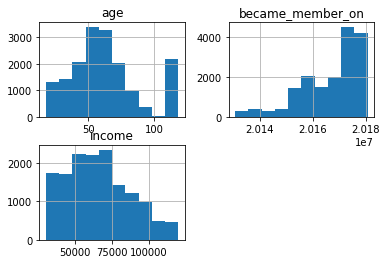

In [4]:
display(profile.head())
print("-----Profile DF Shape-----")
display(profile.shape)
print("-----Profile DF Columns Types-----")
display(profile.dtypes)
print("-----Profile DF Columns Description-----")
display(profile.describe())
print("-----Profile DF Null Variables-----")
display(profile.isnull().sum())
print("-----Profile DF Unique IDs Percentage-----")
print(f"{profile['id'].nunique() / profile.shape[0] *100} %\n")
print("-----Profile DF Numeric Columns Analysis-----")
display(profile.hist())

M    8484
F    6129
O     212
Name: gender, dtype: int64

The percentage of 'Other' gender is: 1.2470588235294118 %


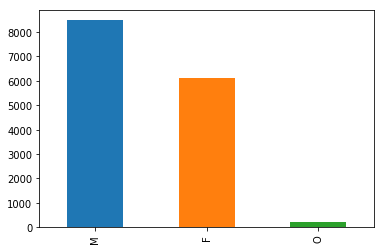

In [5]:
display(profile['gender'].value_counts().plot(kind='bar'))
display(profile['gender'].value_counts())
print(f"The percentage of 'Other' gender is: {profile['gender'].value_counts()['O'] / profile.shape[0] * 100} %")

Since the percentage of others is relatively negligible 1.24% and there is a big amount of NaN in the gender column, we will assume both Other and NaN as information not available and One Hot Encode it as Male 0 and Female 0

But before doing that let's check for the age 118 (which is the encode of NaN for age) what is the gender and income:

In [6]:
print(profile.query('age == 118').isnull().sum())

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


So now we understand that all the ages that are not available have gender and income not available. 

This changes our strategy by deleting those rows (which don't have any relevant information) instead of OHE them

### Preprocessing Profile DF

In [7]:
def preprocess_profile(df):
    """
    Pre-processes the profile dataframe
    
    Input:
        - df
            - type: DataFrame
            - Includes the Profile Dataframe
            
    Output:
        - df
            - type: DataFrame
            - Includes the One Hot Encoded and cleaned profile DF
    """
    # drop the rows having age=118
    empty_age_idx = df.query('age == 118').index
    df.drop(index=empty_age_idx, inplace=True)
    
    # change the format of the date column became_member_on
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    # track how many days the member is on
    df['member_days_duration'] = (datetime.datetime.today() - df['became_member_on']).dt.days

    
    # one hot encoding the gender to 'Male' and 'Female' Columns
    df['Male'] = 0
    df['Female'] = 0
    df.loc[profile.gender == 'M','Male'] = 1
    df.loc[profile.gender == 'F','Female'] = 1
    
    
    df.drop(columns=['gender', 'became_member_on'], inplace=True)
    
    return df

In [8]:
cleaned_profile = preprocess_profile(profile.copy())
display(cleaned_profile.head())
display(cleaned_profile.dtypes)
display(cleaned_profile.isnull().sum())

,age,id,income,member_days_duration,Male,Female
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1778,0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1845,0,1
5,68,e2127556f4f64592b11af22de27a7932,70000.0,1493,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,1569,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1659,1,0


age                       int64
id                       object
income                  float64
member_days_duration      int64
Male                      int64
Female                    int64
dtype: object

age                     0
id                      0
income                  0
member_days_duration    0
Male                    0
Female                  0
dtype: int64

### Distributions after cleaning the profile DF

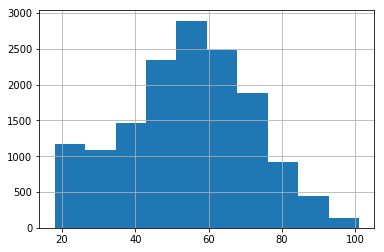

In [9]:
cleaned_profile['age'].hist()

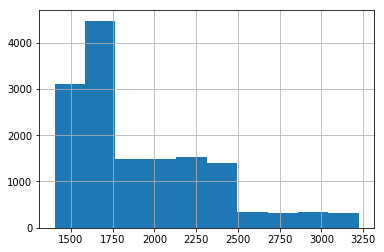

In [10]:
cleaned_profile['member_days_duration'].hist()

## c. Transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


-----Transcript DF Shape-----


(306534, 4)

-----Transcript DF Columns Types-----


event     object
person    object
time       int64
value     object
dtype: object

-----Transcript DF Columns Description-----


,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


-----Transcript DF Null Variables-----


event     0
person    0
time      0
value     0
dtype: int64

-----Transcript Event Types-----


transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

-----Transcript DF Numeric Columns Analysis-----


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fe79df4a8>]], dtype=object)

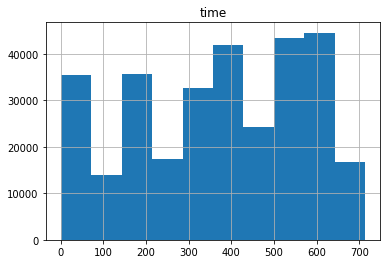

In [11]:
display(transcript.head())
print("-----Transcript DF Shape-----")
display(transcript.shape)
print("-----Transcript DF Columns Types-----")
display(transcript.dtypes)
print("-----Transcript DF Columns Description-----")
display(transcript.describe())
print("-----Transcript DF Null Variables-----")
display(transcript.isnull().sum())
print("-----Transcript Event Types-----")
display(transcript['event'].value_counts())
print("-----Transcript DF Numeric Columns Analysis-----")
display(transcript.hist())

Check if the users we removed (118 as age) have transactions

In [12]:
profile_118 = profile.query('age == 118')
transcript_118 = transcript['person'].isin(profile_118['id'].tolist()).sum()
print(f'Number of transcripts for age 118: {transcript_118}')
print(f'Transcripts with age 118 percentage: {transcript_118/transcript.shape[0]*100} %')

Number of transcripts for age 118: 33772
Transcripts with age 118 percentage: 11.017374907840566 %


In [13]:
transcript.sample(20)

,event,person,time,value
202738,offer received,1f190fc9ded94d448f1061b27521285a,504,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
124813,offer viewed,7b30262eef3d4ea69aa84fa09aee70ed,336,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
3850,offer received,9d3cf2c5c0ab49f98dff4babaa56211a,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
300796,transaction,1e99a5d7cda04316ab07978b5fa641e4,690,{'amount': 27.89}
110547,transaction,09531802efb9407586a3061eefd9cfef,330,{'amount': 7.52}
128509,offer viewed,ad9e18d628fd4771bb3afdc2993cfdd7,342,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
43297,transaction,ccb8f7c05e7745758f0dddff7c7d2ca7,108,{'amount': 15.89}
63313,offer received,7d4dea70cc16493596a9a27d42447a03,168,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
291431,transaction,40abb553ffed4b1aa69d65c96fc0d5a8,648,{'amount': 2.54}
116453,offer received,3aaa8852b90d40c79af6e5791e6c87b7,336,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


We see here that we have in value offer_id if its an offer related event or amount if it is a transaction event

### Preprocessing Transcript DF

In [14]:
def preprocess_transcript(df):
    """
    Pre-processes the transcript dataframe
    
    Input:
        - df
            - type: DataFrame
            - Includes the transcript Dataframe
            
    Output:
        - df
            - type: DataFrame
            - Includes the One Hot Encoded and cleaned transcript DF
    """
    # removing the ids that have age 118
    profile_118 = profile.query('age == 118')
    df = df[~df['person'].isin(profile_118['id'].tolist())]
    
    # One hot Encode the event column
    events = pd.get_dummies(df.event)
    
    # get the offer_id and amount as separate columns
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer id') or x.get('offer_id'))
    df['amount'] = df['value'].apply(lambda x: x.get('amount'))
    
    # drop the value column
    df.drop(columns=['value', 'event'], inplace=True)
    
    # concatinate the original df with event one hot encoded one
    df = pd.concat([df, events], axis=1)
    
    return df

In [15]:
clean_transcript = preprocess_transcript(transcript.copy())
clean_transcript

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,person,time,offer_id,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
12,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,0,1,0,0
13,c27e0d6ab72c455a8bb66d980963de60,0,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
14,d53717f5400c4e84affdaeda9dd926b3,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
15,f806632c011441378d4646567f357a21,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0


For each person, get the total number of offers received and transactions made

Then find the ratio of how many transactions were made having the offers received

In [16]:
grouped_transc = clean_transcript.groupby('person').sum()
grouped_transc['offers_bought'] = round(grouped_transc['transaction']/grouped_transc['offer received'], 2)
grouped_transc.loc[grouped_transc['offers_bought'] > 1] = 1
grouped_transc = grouped_transc.reset_index()
grouped_transc

,person,time,amount,offer completed,offer received,offer viewed,transaction,offers_bought
0,0009655768c64bdeb2e877511632db8f,1,1.00,1,1,1,1,1.00
1,0011e0d4e6b944f998e987f904e8c1e5,6570,79.46,3,5,5,5,1.00
2,0020c2b971eb4e9188eac86d93036a77,1,1.00,1,1,1,1,1.00
3,0020ccbbb6d84e358d3414a3ff76cffd,1,1.00,1,1,1,1,1.00
4,003d66b6608740288d6cc97a6903f4f0,1,1.00,1,1,1,1,1.00
5,00426fe3ffde4c6b9cb9ad6d077a13ea,1,1.00,1,1,1,1,1.00
6,004b041fbfe44859945daa2c7f79ee64,1,1.00,1,1,1,1,1.00
7,004c5799adbf42868b9cff0396190900,1,1.00,1,1,1,1,1.00
8,005500a7188546ff8a767329a2f7c76a,4698,20.36,1,5,3,4,0.80
9,0056df74b63b4298809f0b375a304cf4,1,1.00,1,1,1,1,1.00


In [17]:
clean_grouped_transc = grouped_transc[['person','offers_bought']]
clean_grouped_transc.columns = ['id', 'offers_bought']
clean_grouped_transc

,id,offers_bought
0,0009655768c64bdeb2e877511632db8f,1.00
1,0011e0d4e6b944f998e987f904e8c1e5,1.00
2,0020c2b971eb4e9188eac86d93036a77,1.00
3,0020ccbbb6d84e358d3414a3ff76cffd,1.00
4,003d66b6608740288d6cc97a6903f4f0,1.00
5,00426fe3ffde4c6b9cb9ad6d077a13ea,1.00
6,004b041fbfe44859945daa2c7f79ee64,1.00
7,004c5799adbf42868b9cff0396190900,1.00
8,005500a7188546ff8a767329a2f7c76a,0.80
9,0056df74b63b4298809f0b375a304cf4,1.00


Group the people df with the transactions they made

In [18]:
df_joined = cleaned_profile.merge(clean_grouped_transc, on='id')
df_joined

,age,id,income,member_days_duration,Male,Female,offers_bought
0,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1778,0,1,1.00
1,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1845,0,1,1.00
2,68,e2127556f4f64592b11af22de27a7932,70000.0,1493,1,0,0.75
3,65,389bc3fa690240e798340f5a15918d5c,53000.0,1569,1,0,0.50
4,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1659,1,0,1.00
5,61,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1720,0,1,1.00
6,26,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,3026,1,0,1.00
7,62,31dda685af34476cad5bc968bdb01c53,71000.0,2298,0,1,1.00
8,49,62cf5e10845442329191fc246e7bcea3,52000.0,2753,1,0,1.00
9,57,6445de3b47274c759400cd68131d91b4,42000.0,1609,1,0,1.00


Apply MinMaxScaler to scale all the data to the range of 0 --> 1

In [19]:
scaler = MinMaxScaler()
scaled_DF = df_joined.copy()
columns_to_scale = ['age', 'income', 'member_days_duration']
scaled_DF[columns_to_scale] = scaler.fit_transform(df_joined[columns_to_scale])
scaled_DF.describe()

,age,income,member_days_duration,Male,Female,offers_bought
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.438476,0.393389,0.286604,0.572277,0.413423,0.907094
std,0.209442,0.239981,0.229953,0.494765,0.492464,0.221491
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.289157,0.211111,0.114098,0.000000,0.000000,1.000000
50%,0.445783,0.377778,0.196380,1.000000,0.000000,1.000000
75%,0.578313,0.555556,0.437191,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# pick a random user to test the below functions on
embedding_columns = ['age', 'income', 'member_days_duration', 'Male', 'Female']
main_user = '0610b486422d4921ae7d2bf64640c50b'
main_user_df = scaled_DF.loc[scaled_DF['id'] == main_user, embedding_columns].values

main_user_df

array([[ 0.44578313,  0.91111111,  0.20625343,  0.        ,  1.        ]])

In [21]:
def most_similar_ids (user_id, df, n=10):
    """
    Return the n most similar ids to the user
    
    Input:
        - user_id:
            - type: str
            - User Id to get the similar ids from
        - df:
            - type: Dataframe
            - The DF to get the most similar ids from
        - n:
            - type: int
            - The number of similar ids to find
    Output:
        - sorted_dataframe
            - type: Dataframe
            - DF sorted by most similar users on top
    """
    # main user id to compare with
    embedding_columns = ['age', 'income', 'member_days_duration', 'Male', 'Female']
    user_idx = df.loc[(df.id == user_id )].index[0]
    user_embedding = df.loc[df['id'] == user_id, embedding_columns].values
    
    new_users_embedding = df[embedding_columns].values
    
    df['cosine_similarity'] = 0.0
#     print(user_embedding)
    # add the cosine similarity using numpy to each row
    for i in range(df.shape[0]):
#         new_user_embedding = [df.loc[i, embedding_columns].values]
#         print(new_user_embedding)
        cos_sim = cosine_similarity(user_embedding, [new_users_embedding[i]])
        df['cosine_similarity'][i] = cos_sim
    
    # droppping the non needed column
    #df.drop('features', inplace=True, axis=1)
    # dropping the row of the song queried via its index
    df.drop(user_idx ,axis=0, inplace=True)
    

    # generating the dataframe needed sorted by most similar
    sorted_dataframe = df.sort_values(by="cosine_similarity", ascending = False).head(n)
    
    return sorted_dataframe

In [22]:
def predict(user_reco_df):
    """
    Predict if the user is likely to buy after getting an offer or not
    
    Input:
        - user_reco_df:
            - type: Dataframe
            - Top n users similar to the main user
    
    Output:
        - prediction:
            - Type: Boolean
            - True if the user is likely to buy after an offer, or False in the other case
    """
    avg_offer_score = user_reco_df.offers_bought.mean()
    if avg_offer_score > 0.5:
        return True
    else:
        return False

In [23]:
# Get the top 10 similar users 
recommendations_df = most_similar_ids(main_user, scaled_DF.copy() )

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
recommendations_df

,age,id,income,member_days_duration,Male,Female,offers_bought,cosine_similarity
10338,0.421687,1c518fa4dd634c508d76786db0533600,0.911111,0.201317,0,1,0.60,0.999869
90,0.469880,93e67942586e43fb87d5ffb1ead8db41,0.933333,0.212287,0,1,1.00,0.999857
12770,0.469880,43ab1831aeb0431f98efd3578f14bf67,0.922222,0.197477,0,1,0.50,0.999856
6341,0.445783,84cf0f0cd78e423d9390df1d07a6590e,0.866667,0.199122,0,1,1.00,0.999704
13822,0.409639,598bd781d2a242b6be006823cd161ca8,0.888889,0.212287,0,1,1.00,0.999690
14360,0.457831,2b9476ff747d4974af5679ac8485e5f2,0.955556,0.187054,0,1,1.00,0.999620
2181,0.457831,526338768a7c454788df15d68766a35f,0.900000,0.168952,0,1,1.00,0.999613
14375,0.481928,fb31456ca5794b59b956fb0e068715fa,0.900000,0.190894,0,1,1.00,0.999600
545,0.409639,6dae9375dafb4329b4d69ebbd04fdca7,0.933333,0.196928,0,1,0.83,0.999546
2993,0.457831,855ab85b5bac4be0a9c9aff8cf9d83e2,0.888889,0.167307,0,1,0.80,0.999531


In [25]:
# check the mean (which is used later to generate prediction)
recommendations_df.offers_bought.mean()

0.873

In [26]:
# predict if the user is likely to react positively to an offer
predict(recommendations_df)

True

In [27]:
# check what the user's ratio actually is 
scaled_DF.loc[scaled_DF['id'] == main_user ]

,age,id,income,member_days_duration,Male,Female,offers_bought
0,0.445783,0610b486422d4921ae7d2bf64640c50b,0.911111,0.206253,0,1,1.0


We can see in the above that the user was predicted to react positively to an offer, and the ground truth is actually = 1 which is the highest positive margin for the ratio.

# References

### One Hot Encode from a list 
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list